In [2]:
import sympy
import sympy.physics.mechanics as mech
import control
sympy.init_printing(use_latex='mathjax')
from IPython.display import display
%matplotlib inline

Define BKE Function

In [3]:
def bke(vector, frame_i, frame_b, t):
    return (vector.diff(t, frame_b) + frame_b.ang_vel_in(frame_i).cross(vector))

Define Symbolic Variables

In [4]:
T, r, m_w, m_p, l, F, x, g, alpha, theta, t, R_x, R_z, N, J_p, J_w, v_x, omega, b_emf, b_damp, V, J_motor = \
    sympy.symbols('T r m_w m_p l F x g alpha theta t R_x R_z N J_p J_w v_x omega b_emf b_damp V J_motor')

# Dynamics

Define Reference Frames

In [5]:
frame_i = mech.ReferenceFrame('i') #inertial rame
frame_b = frame_i.orientnew('b', 'Axis', [theta(t), frame_i.y]) #fixed in pendulum
frame_w = frame_b.orientnew('w', 'Axis', [-alpha(t), frame_i.y]) #fixed in wheel

Define Points of Interest

In [6]:
point_o = mech.Point('o') 
point_o.set_vel(frame_i, 0) #point o is inertially fixed

point_W = point_o.locatenew('W', frame_i.x*x(t))  #wheel c.m.
point_W.set_vel(frame_b, 0) #point W is fixed in pendulum frame, too
point_W.set_vel(frame_i, point_W.pos_from(point_o).diff(t, frame_i))

point_P = point_W.locatenew('P', frame_b.z*(-l)) #pendulum c.m.
point_P.set_vel(frame_b, 0)
point_P.v2pt_theory(point_W, frame_i, frame_b);

Creation of the Bodies

In [7]:
# Wheel Creation
J_wheel = mech.inertia(frame_w, 0, J_w, 0)
wheel = mech.RigidBody('wheel', point_W, frame_w, m_w, (J_wheel, point_W))

# Pendulum Creation
J_pend = mech.inertia(frame_b, 0, J_p, 0)
pend = mech.RigidBody('pend', point_P, frame_b, m_p, (J_pend, point_W)) #change inertia point to point_p

## Pendulum

In [8]:
# Pendulum F=ma equation of motion
eom_pend_Newt = bke(pend.linear_momentum(frame_i), frame_i, frame_b, t) \
    - (R_x(t)*frame_i.x) \
    - (-R_z(t)*frame_i.z + m_p*g*frame_i.z)
eom_pend_Newt = eom_pend_Newt.simplify()

#Pendulum Euler's Law
eom_pend_Euler = bke(pend.angular_momentum(point_P, frame_i), frame_i, frame_b, t) \
    - R_x(t)*sympy.cos(theta(t))*(l)*frame_b.y \
    - R_z(t)*sympy.sin(theta(t))*(l)*frame_b.y - (T(t)*frame_b.y)
    

In [9]:
eom_pend_Newt

⎛      2              ⎞
⎜     d               ⎟
⎜m_p⋅───(x(t)) - Rₓ(t)⎟
⎜      2              ⎟
⎝    dt               ⎠ i_x + (-g⋅m_p + R_z(t)) i_z +          2      
        d       
-l⋅m_p⋅───(θ(t))
         2      
       dt        b_x +                 2
      ⎛d       ⎞ 
l⋅m_p⋅⎜──(θ(t))⎟ 
      ⎝dt      ⎠  b_z

In [10]:
eom_pend_Euler

⎛                                                           2             ⎞
⎜                                          ⎛       2    ⎞  d              ⎟
⎜-l⋅Rₓ(t)⋅cos(θ(t)) - l⋅R_z(t)⋅sin(θ(t)) + ⎝J_p - l ⋅m_p⎠⋅───(θ(t)) - T(t)⎟
⎜                                                           2             ⎟
⎝                                                         dt              ⎠ b_y

## Wheel

In [11]:
# Wheel F=ma equation of motion, with reaction force at pin included
eom_wheel_Newt = wheel.linear_momentum(frame_i).diff(t, frame_i) \
    - (F(t)*frame_i.x) - (-R_x(t)*frame_i.x) \
    - R_z(t)*frame_i.z - (-N(t)*frame_i.z) - m_w*g*frame_i.z
    
#Wheel Euler's Law
eom_wheel_Euler = bke(wheel.angular_momentum(point_W, frame_i), frame_i, frame_w, t) \
    - (-T(t)*frame_w.y) - (F(t)*r*frame_w.y)

In [12]:
eom_wheel_Newt

⎛      2                     ⎞
⎜     d                      ⎟
⎜m_w⋅───(x(t)) - F(t) + Rₓ(t)⎟
⎜      2                     ⎟
⎝    dt                      ⎠ i_x + (-g⋅m_w + N(t) - R_z(t)) i_z

In [13]:
eom_wheel_Euler

⎛    ⎛    2           2      ⎞                ⎞
⎜    ⎜   d           d       ⎟                ⎟
⎜J_w⋅⎜- ───(α(t)) + ───(θ(t))⎟ - r⋅F(t) + T(t)⎟
⎜    ⎜    2           2      ⎟                ⎟
⎝    ⎝  dt          dt       ⎠                ⎠ w_y

## Motor

In [14]:
eom_motor = T(t) + b_emf*V(t) - b_damp*alpha(t).diff(t) - J_motor*alpha(t).diff(t,2)
eom_motor

            2                                            
           d                 d                           
- J_motor⋅───(α(t)) - b_damp⋅──(α(t)) + b_emf⋅V(t) + T(t)
            2                dt                          
          dt                                             

## Constraints

In [15]:
no_slip = r*(alpha(t) - theta(t)) - x(t)

no_slip

r⋅(α(t) - θ(t)) - x(t)

# Transform to State Space Form

Take all of the equations of motion and solve them for the variables we need

In [16]:
eoms = sympy.Matrix([eom_pend_Newt.dot(frame_i.x), eom_wheel_Newt.dot(frame_i.x), #in the x direction
    eom_pend_Euler.dot(frame_i.y), eom_wheel_Euler.dot(frame_i.y), #in the y direction (moments)
    eom_pend_Newt.dot(frame_i.z), eom_wheel_Newt.dot(frame_i.z), #in the z direction
    eom_motor, #the equation of motion for the motor
    no_slip,
    no_slip.diff(t),
    no_slip.diff(t,2)]) #the constraint equation
eoms

⎡                          2                     2               2            
⎢                ⎛d       ⎞                     d               d             
⎢l⋅m_p⋅sin(θ(t))⋅⎜──(θ(t))⎟  - l⋅m_p⋅cos(θ(t))⋅───(θ(t)) + m_p⋅───(x(t)) - Rₓ(
⎢                ⎝dt      ⎠                      2               2            
⎢                                              dt              dt             
⎢                                                                             
⎢                               2                                             
⎢                              d                                              
⎢                         m_w⋅───(x(t)) - F(t) + Rₓ(t)                        
⎢                               2                                             
⎢                             dt                                              
⎢                                                                             
⎢                                                   

In [17]:
eom_sol = sympy.solve(eoms, [T(t), N(t), R_x(t), R_z(t), F(t), theta(t).diff(t,2), alpha(t).diff(t,2), x(t).diff(t,2), alpha(t).diff(t), alpha(t)], simplify=False)
eom_sol

⎧                                                                             
⎪                                                                             
⎪                                                                             
⎨                                                                             
⎪F(t): - ─────────────────────────────────────────────────────────────────────
⎪                     2            2      2    2                  2      2    
⎩        J_motor⋅J_w⋅r  + J_motor⋅l ⋅m_p⋅r ⋅sin (θ(t)) + J_motor⋅l ⋅m_p⋅r ⋅cos

                                                                              
                                                                              
                                           ⎛           2              2    2  
                                     b_emf⋅⎝J_w⋅l⋅m_p⋅r ⋅cos(θ(t)) - l ⋅m_p ⋅r
──────────────────────────────────────────────────────────────────────────────
2                          3                       

Now we have solved for each of the unknown variables in terms of system properties and theta,
the next step is to look specifically at the variables of most importance, x_dot and theta_dot

In [18]:
simp_assump = {J_w:0, J_motor:0, m_w:0}
theta_ddot = eom_sol[theta(t).diff(t,2)].expand().ratsimp().collect([theta(t), x(t), V(t), theta(t).diff(t), x(t).diff(t)], sympy.factor)
theta_ddot = theta_ddot.subs(simp_assump)

theta_ddot

                                                                              
         ⎛                         2⎞ d                 ⎛                     
b_damp⋅r⋅⎝l⋅m_p⋅r⋅cos(θ(t)) + m_p⋅r ⎠⋅──(θ(t)) + b_damp⋅⎝l⋅m_p⋅r⋅cos(θ(t)) + m
                                      dt                                      
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                                                             r

                                                                              
    2⎞ d                  ⎛                         2⎞               2  3     
_p⋅r ⎠⋅──(x(t)) - b_emf⋅r⋅⎝l⋅m_p⋅r⋅cos(θ(t)) + m_p⋅r ⎠⋅V(t) + g⋅l⋅m_p ⋅r ⋅sin(
       dt                                                                     
──────────────────────────────────────────────────────────────────────────────
 ⎛         2    2    2  2    2          2    2  2⎞ 

In [19]:
x_ddot = eom_sol[x(t).diff(t,2)].expand().ratsimp().collect([theta(t), x(t), V(t), theta(t).diff(t), x(t).diff(t)], sympy.factor)
x_ddot = x_ddot.subs(simp_assump)
x_ddot

                                                                              
         ⎛       2        2          2        2          2                    
b_damp⋅r⋅⎝J_p + l ⋅m_p⋅sin (θ(t)) + l ⋅m_p⋅cos (θ(t)) - l ⋅m_p + l⋅m_p⋅r⋅cos(θ
                                                                              
──────────────────────────────────────────────────────────────────────────────
                                                                              
                                                                              

                                                                              
    ⎞ d                 ⎛       2        2          2        2          2     
(t))⎠⋅──(θ(t)) + b_damp⋅⎝J_p + l ⋅m_p⋅sin (θ(t)) + l ⋅m_p⋅cos (θ(t)) - l ⋅m_p 
      dt                                                                      
──────────────────────────────────────────────────────────────────────────────
                                                   

Next to make things look a little nicer, create a dict that can replace f(t) with a new variable that doesnt have the (t)

In [20]:
remove_t = {x(t).diff(t): v_x, x(t): x, theta(t).diff(t): omega, theta(t): theta, alpha(t): alpha, V(t): V, T(t): T} #defines the dict



Create state vector X, input vector U, derivative of state vector Xdot

In [21]:
X = sympy.Matrix([x(t), x(t).diff(t), theta(t), theta(t).diff(t)]).subs(remove_t) #state vector
U = sympy.Matrix([V(t)]).subs(remove_t) #Input torque
Xdot = sympy.Matrix([x(t).diff(t), x_ddot, theta(t).diff(t), theta_ddot]).subs(remove_t)
X, U

⎛⎡x ⎤, [V]⎞
⎜⎢  ⎥     ⎟
⎜⎢vₓ⎥     ⎟
⎜⎢  ⎥     ⎟
⎜⎢θ ⎥     ⎟
⎜⎢  ⎥     ⎟
⎝⎣ω ⎦     ⎠

Define the state space matricies A, B, C, and D. They are defined by the Jacobians.  A Jacobian is a matrix consisting of partial derivatives of each function and all independent variables

In [22]:
A = Xdot.jacobian(X)
B = Xdot.jacobian(U)
C = X.jacobian(X)
D = X.jacobian(U)
ss = [A, B, C, D]

These matricies still are in terms of trig functions and angular rates squared and are thus non-linear.  However, we can assume the system behaves linearly about the operating point, and so evaluate the elements of the state space matricies at the operating point.

In [23]:
stop_eq_point = {T: 0, omega: 0, theta: 0, v_x: 0} #a dict of the equilibrium points when the segway is not moving
ss0 = [A.subs(stop_eq_point), B.subs(stop_eq_point), C, D]
ss0

⎡⎡0               1                          0                         0      
⎢⎢                                                                            
⎢⎢                                         2    2  2                          
⎢⎢      b_damp⋅(J_p + l⋅m_p⋅r)          g⋅l ⋅m_p ⋅r        b_damp⋅r⋅(J_p + l⋅m
⎢⎢0    ───────────────────────    ───────────────────────  ───────────────────
⎢⎢              2    2    2  2             2    2    2  2           2    2    
⎢⎢     J_p⋅m_p⋅r  - l ⋅m_p ⋅r     J_p⋅m_p⋅r  - l ⋅m_p ⋅r   J_p⋅m_p⋅r  - l ⋅m_p
⎢⎢                                                                            
⎢⎢0               0                          0                         1      
⎢⎢                                                                            
⎢⎢           ⎛               2⎞                2  2               ⎛           
⎢⎢    b_damp⋅⎝l⋅m_p⋅r + m_p⋅r ⎠         g⋅l⋅m_p ⋅r         b_damp⋅⎝l⋅m_p⋅r + m
⎢⎢0  ───────────────────────────  ──────────────────

In [24]:
sub_const = {
    J_p: 2,
    b_damp: 0,
    b_emf: 1,
    g: 9.8,
    l: 1,
    r: 0.1,
    m_p: 1,
}

In [25]:
import pylab as pl

In [26]:
ss0

⎡⎡0               1                          0                         0      
⎢⎢                                                                            
⎢⎢                                         2    2  2                          
⎢⎢      b_damp⋅(J_p + l⋅m_p⋅r)          g⋅l ⋅m_p ⋅r        b_damp⋅r⋅(J_p + l⋅m
⎢⎢0    ───────────────────────    ───────────────────────  ───────────────────
⎢⎢              2    2    2  2             2    2    2  2           2    2    
⎢⎢     J_p⋅m_p⋅r  - l ⋅m_p ⋅r     J_p⋅m_p⋅r  - l ⋅m_p ⋅r   J_p⋅m_p⋅r  - l ⋅m_p
⎢⎢                                                                            
⎢⎢0               0                          0                         1      
⎢⎢                                                                            
⎢⎢           ⎛               2⎞                2  2               ⎛           
⎢⎢    b_damp⋅⎝l⋅m_p⋅r + m_p⋅r ⎠         g⋅l⋅m_p ⋅r         b_damp⋅⎝l⋅m_p⋅r + m
⎢⎢0  ───────────────────────────  ──────────────────

In [27]:
sys0 = control.ss(*[pl.array(mat_i.subs(sub_const)).astype(float) for mat_i in ss0])
sys0

A = [[ 0.   1.   0.   0. ]
 [ 0.   0.   9.8  0. ]
 [ 0.   0.   0.   1. ]
 [ 0.   0.   9.8  0. ]]

B = [[  0.]
 [-21.]
 [  0.]
 [-11.]]

C = [[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]

D = [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]

In [28]:
def tf_clean(tf, tol=1e-3):
    import copy
    num = copy.deepcopy(tf.num)
    den = copy.deepcopy(tf.den)
    for i_u in range(tf.inputs):
        for i_y in range(tf.outputs):
            num[i_y][i_u] = pl.where(abs(num[i_y][i_u]) < tol, pl.zeros(num[i_y][i_u].shape), num[i_y][i_u])
            den[i_y][i_u] = pl.where(abs(den[i_y][i_u]) < tol, pl.zeros(den[i_y][i_u].shape), den[i_y][i_u])
    return control.tf(num,den)

In [29]:
tf_20 = tf_clean(control.ss2tf(sys0[2,0]))
tf_20


   -11
---------
s^2 - 9.8

Figure out pole zero cancellation in python control toolbox.

In [30]:
tf_20 = control.tf([-11],[1,0,-9.8])
tf_20


   -11
---------
s^2 - 9.8

/usr/local/lib/python2.7/dist-packages/control/freqplot.py:124: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if (omega == None):


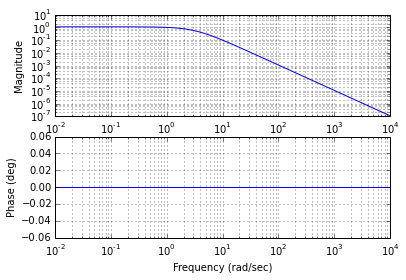

In [31]:
control.bode(tf_20, omega=pl.logspace(-2,4));

array([-20,  20, -20,  20])

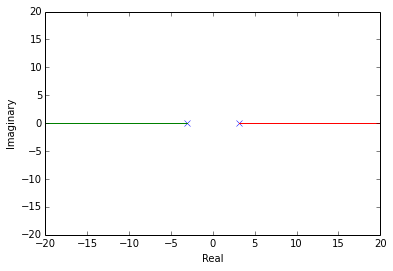

In [32]:
control.rlocus(tf_20);
pl.axis(20*pl.array([-1,1,-1,1]))

In [33]:
K, S, E = control.lqr(sys0.A, sys0.B, pl.eye(sys0.A.shape[0]), pl.eye(sys0.B.shape[1]))
K, S, E

(array([[  1.        ,   2.00048462, -14.2631815 ,  -6.44414536]]),
 array([[  2.00048462,   1.50096935,  -6.44414536,  -2.95639604],
        [  1.50096935,   2.27934366,  -9.93501762,  -4.5333365 ],
        [ -6.44414536,  -9.93501762,  45.78496013,  20.26350468],
        [ -2.95639604,  -4.5333365 ,  20.26350468,   9.2403829 ]]),
 array([-23.94398880+0.j        ,  -1.00657153+0.j        ,
         -1.96243072+0.46371317j,  -1.96243072-0.46371317j], dtype=complex64))

In [34]:
eom

NameError: name 'eom' is not defined

In [ ]:
import scipy.integrate

sim = scipy.integrate.ode(

In [ ]:
print Xdot

In [ ]:
print X
print U

In [ ]:
x_vect = sympy.DeferredVector('x')
u_vect = sympy.DeferredVector('u')
ss_sub = {X[i]:x_vect[i] for i in range(len(X))}
ss_sub.update({U[i]:u_vect[i] for i in range(len(U))})
ss_sub

In [ ]:
Xdot.subs(sub_const).subs(ss_sub)

In [ ]:
print x

In [ ]:
print Xdot.subs(sub_const)

In [ ]:
import numpy
f_eval = sympy.lambdify([t, x_vect, u_vect], Xdot.subs(sub_const).subs(ss_sub),
                        [{'ImmutableMatrix': numpy.array}, 'numpy'])
f_eval(0, pl.array([0,0,0,0]), pl.array([0]))

In [ ]:
sim = scipy.integrate.ode(f_eval)
x0 = [0.5,0,0.5,0]
u = 0
sim.set_initial_value(x0)
sim.set_f_params(u)
dt = 0.01
tf = 2
data = {
    't': [],
    'u': [],
    'y': [],
    'x': [],
}

while sim.t + dt < tf:
    x = sim.y
    y = x # fix
    u = -K.dot(x)
    sim.set_f_params(u)
    sim.integrate(sim.t + dt)
    data['t'].append(sim.t)
    data['u'].append(u)
    data['x'].append(x)
    data['y'].append(y)
    

In [ ]:
h_nl = pl.plot(data['t'], data['y'], 'r-');
sysc = sys0.feedback(K)
t, y, x = control.forced_response(sysc, X0=x0, T=pl.linspace(0,tf), transpose=True)
h_l = pl.plot(t, y, 'k--');
pl.legend([h_nl[0], h_l[0]], ['non-linear', 'linear'], loc='best')
pl.grid()